# Examine the relationship between horizontal salinity gradients and numerical mixing for the parent and child models.
Smolarkiewicz (1983) showed that $    \frac{1}{2}(|u|\Delta x-u^2 \Delta t) \big(\frac{\partial s}{\partial x} \big)^2 = \frac{1}{2}|u|\Delta x \big(1-\frac{u \Delta t}{\Delta x} \big)\big(\frac{\partial s}{\partial x} \big)^2,$

Here, we modify this to investigate the relationship between $\mathcal{M}_{num, on}$ and $\big(\frac{\partial s}{\partial x} \big)^2+\big(\frac{\partial s}{\partial y} \big)^2$ 

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grida
import xarray as xr
import xroms
import glob
from datetime import datetime
from xhistogram.xarray import histogram
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 11})
import matplotlib.dates as mdates
import matplotlib.ticker as tick

# Save the numerical mixing, salinity gradient magnitude, and grid cell volume dV before starting the regression analysis. I've commented it out since I've already run it 

In [2]:
# path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
# ds = xroms.open_mfnetcdf(path)
# ds, grid = xroms.roms_dataset(ds)

# #Indexing for nested grid
# xislice = slice(271,404)
# etaslice = slice(31,149)

# path1 = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_0000*.nc')
# ds_child = xroms.open_mfnetcdf(path1)
# ds_child, grid_child = xroms.roms_dataset(ds_child)

# xislicechild = slice(8, 677-8)
# etaslicechild = slice(8, 602-8)

# #Match the times of the parent and child models. Drop the first timestep after
# #each restart, then match parent / child. They differ bc the model crashed mid run
# timedrop = [np.datetime64('2010-06-18T18:30:00.000000000'), 
#             np.datetime64('2010-06-19T18:30:00.000000000'), 
#             np.datetime64('2010-07-09T18:30:00.000000000')]

# ds_child = ds_child.where((ds_child.ocean_time!= timedrop[0])
#                            & (ds_child.ocean_time!= timedrop[1])
#                            & (ds_child.ocean_time!= timedrop[2]),
#                               drop=True)

# ds = ds.where(ds_child.ocean_time==ds.ocean_time)

# def salinity_gradient_mag(ds, grid):
#     '''
# Computes the salinity gradient magnitude for the entire
# water column on the rho points.
#     ''' 
#     dsaltdxi, dsaltdeta = xroms.hgrad(ds.salt, grid)
#     dsaltdxi_rho = grid.interp(xroms.to_rho(dsaltdxi, grid), 'Z')
#     dsaltdeta_rho = grid.interp(xroms.to_rho(dsaltdeta, grid), 'Z')
#     sgradmag = (dsaltdxi_rho**2+dsaltdeta_rho**2)**(1/2)
#     sgradmag.attrs = ''
#     sgradmag.name = 'sgradmag'
    
#     return sgradmag

# #Salinity gradient magnitude 
# sgradmag_whole = salinity_gradient_mag(ds, grid)
# sgradmag = sgradmag_whole.isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time = slice('2010-06-03', '2010-07-14'))
# sgradmag.attrs = ''
# sgradmag.name = 'sgradmag'

# #Numerical mixing 
# mnum_rho = ds.dye_03
# mnum = mnum_rho.isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time = slice('2010-06-03', '2010-07-14'))
# mnum.attrs = ''
# mnum.name = 'mnum'

# dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time = slice('2010-06-03', '2010-07-14'))
# dV.attrs = ''
# dV.name = 'dV'

# #Child grid --------
# sgradmag_whole_child = salinity_gradient_mag(ds_child, grid_child)
# sgradmag_child = sgradmag_whole_child.isel(eta_rho = etaslicechild, xi_rho = xislicechild).sel(ocean_time = slice('2010-06-03', '2010-07-14'))
# sgradmag_child.attrs = ''
# sgradmag_child.name = 'sgradmag'

# mnum_rho_child = ds_child.dye_03.sel(ocean_time = slice('2010-06-03', '2010-07-14'))
# mnum_child = mnum_rho_child.isel(eta_rho = etaslicechild, xi_rho = xislicechild)
# mnum_child.attrs = ''
# mnum_child.name = 'mnum'

# dV_child = ds_child.dV.isel(eta_rho = etaslicechild, xi_rho = xislicechild).sel(ocean_time = slice('2010-06-03', '2010-07-14'))
# dV_child.attrs = ''
# dV_child.name = 'dV'

# #Save the data to a netcdf file 
# mnum.to_netcdf('mnum.nc')
# sgradmag.to_netcdf('sgradmag.nc')
# dV.to_netcdf('dV.nc')

# mnum_child.to_netcdf('mnum_child.nc')
# sgradmag_child.to_netcdf('sgradmag_child.nc')
# dV_child.to_netcdf('dV_child.nc')

# Open data for saving to histograms. We square the salinity gradient magnitude

In [3]:
mnum = xr.open_dataset('../analysis_notebooks/mnum.nc', chunks=dict(ocean_time = 1)).mnum.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
sgradmag = xr.open_dataset('../analysis_notebooks/sgradmag.nc', chunks=dict(ocean_time = 1)).sgradmag.sel(ocean_time = slice('2010-06-03', '2010-07-13'))**2
dV = xr.open_dataset('../analysis_notebooks/dV.nc', chunks=dict(ocean_time = 1)).dV.sel(ocean_time = slice('2010-06-03', '2010-07-13'))

mnum_child = xr.open_dataset('../analysis_notebooks/mnum_child.nc', chunks=dict(ocean_time = 1)).mnum.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
sgradmag_child = xr.open_dataset('../analysis_notebooks/sgradmag_child.nc', chunks=dict(ocean_time = 1)).sgradmag.sel(ocean_time = slice('2010-06-03', '2010-07-13'))**2
dV_child = xr.open_dataset('../analysis_notebooks/dV_child.nc', chunks=dict(ocean_time = 1)).dV.sel(ocean_time = slice('2010-06-03', '2010-07-13'))

mnum_subsample = mnum[:,:,::3,::3]
sgradmag_subsample = sgradmag[:,:,::3,::3]
dV_subsample = dV[:,:,::3,::3]

mnum_subsample_child = mnum_child[:,:,::15,::15]
sgradmag_subsample_child = sgradmag_child[:,:,::15,::15]
dV_subsample_child = dV_child[:,:,::15,::15]

# Save whole water column histograms

In [4]:
# #Save parent model histograms
# mnumbins_log = np.linspace(-11,-3, 250)
# sgradbins_log = np.linspace(-13,-5, 250)

# sgradmag_joint = histogram(np.log10(sgradmag), 
#                            np.log10(np.abs(mnum)), 
#                            bins = [sgradbins_log, mnumbins_log], 
#                            weights = dV,
#                            dim = ['xi_rho', 's_rho', 'eta_rho', 'ocean_time'],
#                            density = False)
# sgradmag_joint.name = 'mnum_histogram'
# sgradmag_joint.to_netcdf('histogram_mnum_sgradmag_dV_joint_logspace_parent_whole_weighted.nc')

In [5]:
# sgradmag_joint_child = histogram(np.log10(sgradmag_child), 
#                                  np.log10(np.abs(mnum_child)), 
#                                  bins = [sgradbins_log, mnumbins_log], 
#                                  weights = dV_child,
#                                  dim = ['xi_rho', 's_rho', 'eta_rho', 'ocean_time'],
#                                  density = False)
# sgradmag_joint_child.name = 'mnum_histogram'
# sgradmag_joint_child.to_netcdf('histogram_mnum_sgradmag_dV_joint_logspace_child_whole_weighted.nc')

# Save subsetted histograms and compare 

In [6]:
# #Save parent model histograms
# mnumbins_log = np.linspace(-11,-3, 250)
# sgradbins_log = np.linspace(-13,-5, 250)

# #Make sure the data are subsetted from June 3 to the end of July 14 to match tracer variance budgets 
# sgradmag_joint = histogram(np.log10(sgradmag_subsample), 
#                            np.log10(np.abs(mnum_subsample)), 
#                            bins = [sgradbins_log, mnumbins_log], 
#                            weights = dV_subsample,
#                            dim = ['xi_rho', 's_rho', 'eta_rho', 'ocean_time'],
#                            density = False)
# sgradmag_joint.name = 'mnum_histogram'
# sgradmag_joint.to_netcdf('histogram_mnum_sgradmag_dV_joint_logspace_parent_subsample_weighted.nc')

In [7]:
# sgradmag_joint_child = histogram(np.log10(sgradmag_subsample_child), 
#                                  np.log10(np.abs(mnum_subsample_child)), 
#                                  bins = [sgradbins_log, mnumbins_log], 
#                                  weights = dV_subsample_child,
#                                  dim = ['xi_rho', 's_rho', 'eta_rho', 'ocean_time'],
#                                  density = False)
# sgradmag_joint_child.name = 'mnum_histogram'
# sgradmag_joint_child.to_netcdf('histogram_mnum_sgradmag_dV_joint_logspace_child_subsample_weighted.nc')

# Open the histograms and plot them before doing the linear regression 

In [8]:
parent_joint = xr.open_mfdataset('histogram_mnum_sgradmag_dV_joint_logspace_parent_whole_weighted.nc').mnum_histogram
child_joint = xr.open_mfdataset('histogram_mnum_sgradmag_dV_joint_logspace_child_whole_weighted.nc').mnum_histogram
hist_diff = child_joint-parent_joint

Text(0.5, 0, '$(\\partial_x s)^2+(\\partial_y s)^2$ [g kg$^{-1}$ m$^{-1}$]')

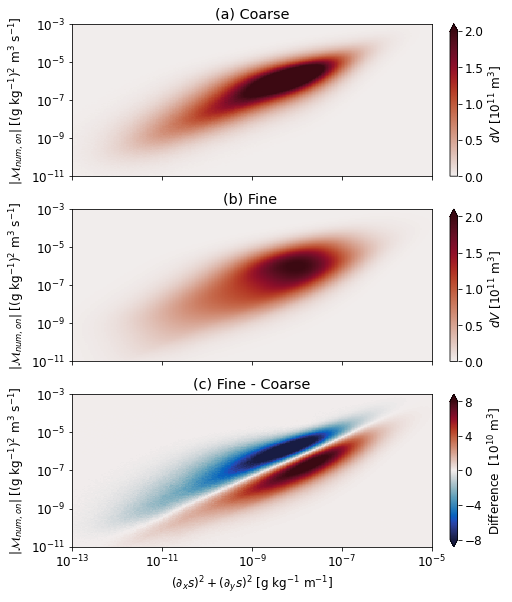

In [9]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(3,1, figsize = (7,2.5*3.3), sharex = True, sharey = True, constrained_layout = True)

mappable = (parent_joint.T/1e11).plot(ax = ax[0], cmap = cmo.amp, add_colorbar = False, vmin = 0, vmax = 2)
cbar = fig.colorbar(mappable, ax = ax[0], extend = 'max', label = r'$dV$ [$10^{11}$ m$^3$]', pad = 0.01)
mappable1 = (child_joint.T/1e11).plot(ax = ax[1], cmap = cmo.amp, add_colorbar = False, vmin = 0, vmax = 2)
cbar = fig.colorbar(mappable1, ax = ax[1], extend = 'max', label = r'$dV$ [$10^{11}$ m$^3$]', pad = 0.01)
mappable2 = (hist_diff.T/1e10).plot(ax = ax[2], cmap = cmo.balance, add_colorbar = False, vmin = -8, vmax = 8)
cbar = fig.colorbar(mappable2, ax = ax[2], extend = 'both', label = r'Difference  [$10^{10}$ m$^3$]', ticks = [-8,-4,0,4,8], pad = 0.01)

for i in range(3):
    ax[i].set_xlabel('')
    ax[i].set_yticks([-11, -9, -7,-5,-3])
    ax[i].set_xticks([-13, -11, -9, -7,-5])
    ax[i].set_yticklabels(['10$^{-11}$', '10$^{-9}$', '10$^{-7}$', '10$^{-5}$', '10$^{-3}$'])
ax[i].set_xticklabels(['10$^{-13}$', '10$^{-11}$', '10$^{-9}$', '10$^{-7}$', '10$^{-5}$'])

for i in range(3):
    ax[i].set_ylabel(r'$|\mathcal{M}_{num,on}|$ [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')
    
ax[0].set_title('(a) Coarse')
ax[1].set_title('(b) Fine ')
ax[2].set_title('(c) Fine - Coarse')
ax[2].set_xlabel(r'$(\partial_x s)^2+(\partial_y s)^2$ [g kg$^{-1}$ m$^{-1}$]')

In [10]:
def polyfit(x, y, degree, weights):
    '''
Fits x and y to an n degree polynomial, allows for weights to be added
  and returns the coefficients: i.e. y = ax + b and the coefficient of 
  determination based on weighted regrression. 
  
Inputs: 
------
x: x variable for WLS
y: desired y variable for WLS
degree: fit of polynomial (1 for linear)
weights: Vector of weights

Outputs:
------
results: Contains slope and y-intercept of regression
r2: Weighted coefficient of determination

Notes: 
------
r^2 = 1 - (SSR/SST), where
SSR = sum(w_i(y_i - y^hat)^2)
SST = sum(w_i(y_i - ybar)^2),
w_i = weights, i.e., dV
y_i = observed value of y
y^hat = predicted y value by WLS regression
ybar = weighted average value of observed y...
ybar = sum(w_i*y_i)/sum(w_i)
  
Source: Willett and Singer (1988) Another Cautionary Note...
    '''    
    results = {}

    coeffs = np.polyfit(x, y, degree, w = weights)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()
    
    #Predicted values for r^2
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)
    
    #Compute r^2 using 
    ss_residual = sum(weights*(y-yhat)**2)
    ss_total = sum(weights*(y-np.average(y, weights = weights))**2)
    r2 = (1-(ss_residual/ss_total))
    
    return results, r2

In [11]:
mnum_stack = mnum_subsample.stack(z = ['ocean_time', 's_rho', 'eta_rho', 'xi_rho']).values
sgradmag_stack = sgradmag_subsample.stack(z = ['ocean_time', 's_rho', 'eta_rho', 'xi_rho']).values
dV_stack = dV_subsample.stack(z = ['ocean_time', 's_rho', 'eta_rho', 'xi_rho']).values

In [12]:
x = np.log10(sgradmag_stack) #salinity gradient magnitude
y = np.log10(np.abs(mnum_stack)) #numerical mixing
deg = 1 #linear fit in log space
w = np.sqrt(dV_stack) #weights 

#Run the fitting function
results_weighted, r2 = polyfit(x, y, deg, w) #weighted
print(results_weighted, r2)

{'polynomial': [0.8070237945318924, 0.5902091737236543]} 0.6019291044103474


In [13]:
#Sort 
mnum_sort = np.sort(x)

#Create a vector of values for numerical mixing equal to the length of the stacked salinity gradient
xwhole = np.linspace(mnum_sort[0], mnum_sort[-1], 1000)
y_pred_weighted = results_weighted['polynomial'][0]*xwhole+results_weighted['polynomial'][1]

In [14]:
results_weighted['polynomial'][1]

0.5902091737236543

# Try to fit a line where the slope equals one. Need to calculate the y-intercept first 

In [15]:
from scipy.optimize import curve_fit

# objective function
def objective(x, a, b):
    return a * x + b 

# fit curve - need to prescribe the weights as 1/w this time bc the function is different
popt, _ = curve_fit(objective, x, y, sigma = 1/w)
popt

# define new input values
x_line = xwhole
# unpack optima parameters for the objective function
a, b = popt
# use optimal parameters to calculate new values
y_new = objective(x_line, a, b)

In [16]:
#Predicted values for r^2
p = np.poly1d(np.array([a,b]))
# fit values, and mean
yhat = p(x)

#Compute r^2 using 
ss_residual = sum(w*(y-yhat)**2)
ss_total = sum(w*(y-np.average(y, weights = w))**2)
r2 = (1-(ss_residual/ss_total))

Text(-12.9, -4.25, '$\\log_{10}|\\mathcal{M}_{num, on}|=$ 0.81$\\log_{10} (\\nabla_H s)^2$ + 0.59, $r^2 = $0.602')

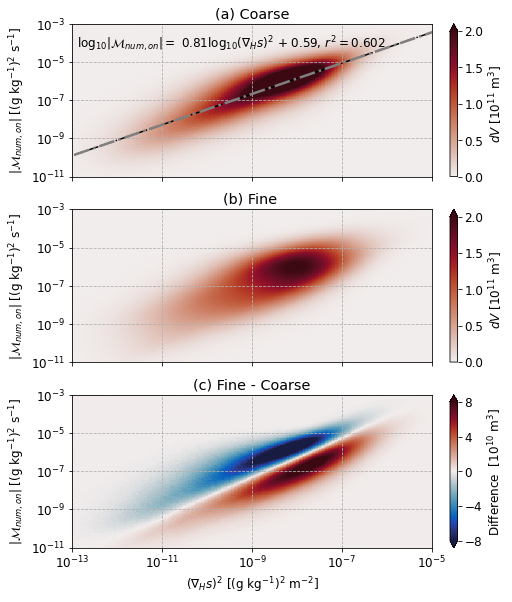

In [17]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(3,1, figsize = (7,2.5*3.3), sharex = True, sharey = True, constrained_layout = True)

mappable = (parent_joint.T/1e11).plot(ax = ax[0], cmap = cmo.amp, add_colorbar = False, vmin = 0, vmax = 2)
cbar = fig.colorbar(mappable, ax = ax[0], extend = 'max', label = r'$dV$ [$10^{11}$ m$^3$]', pad = 0.01)
mappable1 = (child_joint.T/1e11).plot(ax = ax[1], cmap = cmo.amp, add_colorbar = False, vmin = 0, vmax = 2)
cbar = fig.colorbar(mappable1, ax = ax[1], extend = 'max', label = r'$dV$ [$10^{11}$ m$^3$]', pad = 0.01)
mappable2 = (hist_diff.T/1e10).plot(ax = ax[2], cmap = cmo.balance, add_colorbar = False, vmin = -8, vmax = 8)
cbar = fig.colorbar(mappable2, ax = ax[2], extend = 'both', label = r'Difference  [$10^{10}$ m$^3$]', ticks = [-8,-4,0,4,8], pad = 0.01)

for i in range(3):
    ax[i].set_xlabel('')
    ax[i].set_yticks([-11, -9, -7,-5,-3])
    ax[i].set_xticks([-13, -11, -9, -7,-5])
    ax[i].set_yticklabels(['10$^{-11}$', '10$^{-9}$', '10$^{-7}$', '10$^{-5}$', '10$^{-3}$'])
ax[i].set_xticklabels(['10$^{-13}$', '10$^{-11}$', '10$^{-9}$', '10$^{-7}$', '10$^{-5}$'])

for i in range(3):
    ax[i].set_ylabel(r'$|\mathcal{M}_{num,on}|$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
    ax[i].grid(ls = '--')
    # ax[i].grid(ls = '--')
    
ax[0].set_title('(a) Coarse')
ax[1].set_title('(b) Fine ')
ax[2].set_title('(c) Fine - Coarse')
ax[2].set_xlabel(r'$(\nabla_H s)^2$ [(g kg$^{-1}$)$^2$ m$^{-2}$]')

ax[0].plot(xwhole, y_pred_weighted, lw = 1.5, ls = '-.', c = 'k')
ax[0].plot(xwhole, y_new, lw = 2.5, ls = '-.', c = 'grey')
# ax[0].plot(xwhole, y_pred_weighted1, lw = 1.5, ls = '-.', c = 'grey')
# ax[1].plot(xwhole_child, y_pred_weighted_child, lw = 1.5, ls = '-.', c = 'k')
# ax[1].plot(xwhole_child, y_pred_weighted_child1, lw = 1.5, ls = '-.', c = 'grey')
ax[0].text(-12.9, -4.25, r'$\log_{10}|\mathcal{M}_{num, on}|=$ ' + str(round(results_weighted['polynomial'][0], 2)) + r'$\log_{10} (\nabla_H s)^2$ + ' + str(round(np.abs(results_weighted['polynomial'][1]), 2)) + ', $r^2 = $' + str(round(r2, 3)))
# ax[1].text(-12.9, -4.25, r'$\log_{10}|\mathcal{M}_{num, on}|=$ ' + str(round(results_weighted_child['polynomial'][0], 2)) + r'$\log_{10} (\nabla_H s)^2$ - ' + str(round(np.abs(results_weighted_child['polynomial'][1]), 2)) + ', $r^2 = $' + str(round(r2_child, 3)))
# ax[2].plot(xwhole_child, y_pred_weighted_child1, lw = 1.5, ls = '-.', c = 'grey')
# fig.savefig('/d2/home/dylan/JAMES/figures/draft1/histogram_discussion_flipped.jpg', dpi = 300, bbox_inches="tight")     

# Good - so using scipy.curve_fit yields the same results. Now let's redefine the objective function 

In [18]:
# objective function
def objective1(x, b):
    return x + b 

x1 = np.log10(sgradmag_stack) #salinity gradient magnitude
y1 = np.log10(np.abs(mnum_stack)) #numerical mixing
w1 = np.sqrt(dV_stack) #weights 

# fit curve
popt1, _ = curve_fit(objective1, x1, y1, sigma = 1/w1)
popt1

# unpack optima parameters for the objective function
b1 = popt1
# use optimal parameters to calculate new values
y_new1 = objective1(x_line, b1)

In [19]:
#Predicted values for r^2
p = np.poly1d(np.array([1, b1[0]]))
# fit values, and mean
yhat = p(x1)
#Compute r^2 using 
ss_residual = sum(w*(y1-yhat)**2)
ss_total = sum(w*(y1-np.average(y, weights = w1))**2)
r2_1 = (1-(ss_residual/ss_total))

In [20]:
#Predicted values for r^2
p = np.poly1d(np.array([1, b1[0]]))
# fit values, and mean
yhat = p(x1)
w2 = 1/w1
#Compute r^2 using 
ss_residual = sum(w2*(y1-yhat)**2)
ss_total = sum(w2*(y1-np.average(y, weights = w2))**2)
r2_12 = (1-(ss_residual/ss_total))
r2_12

0.4837884862762636

# Repeat for the child model 

In [21]:
mnum_stackchild = mnum_subsample_child.stack(z = ['ocean_time', 's_rho', 'eta_rho', 'xi_rho']).values
sgradmag_stackchild = sgradmag_subsample_child.stack(z = ['ocean_time', 's_rho', 'eta_rho', 'xi_rho']).values
dV_stackchild = dV_subsample_child.stack(z = ['ocean_time', 's_rho', 'eta_rho', 'xi_rho']).values

x_child = np.log10(sgradmag_stackchild)
y_child = np.log10(np.abs(mnum_stackchild))
deg = 1 #linear fit in log space
w_child = np.sqrt(dV_stackchild) #weights 

#Run the fitting function
results_weighted_child, r2_child = polyfit(x_child, y_child, deg, w_child) #weighted
print(results_weighted_child, r2_child)

{'polynomial': [0.7565483350041383, -0.19412111722427394]} 0.4622398018292556


In [22]:
#Sort 
mnum_sort_child = np.sort(x_child)

#Create a vector of values for numerical mixing equal to the length of the stacked salinity gradient
xwhole_child = np.linspace(mnum_sort_child[0], mnum_sort_child[-1], 1000)

# fit curve - need to prescribe the weights as 1/w this time bc the function is different
popt_child, _ = curve_fit(objective1, x_child, y_child, sigma = 1/w_child)
popt_child

# define new input values
x_line_child= xwhole_child
# unpack optima parameters for the objective function
b_child = popt_child
# use optimal parameters to calculate new values
y_new_child = objective1(x_line_child, b_child)

In [23]:
#Predicted values for r^2
p_child = np.poly1d(np.array([1, b_child[0]]))
# fit values, and mean
yhat_child = p_child(x_child)

#Compute r^2 using 
ss_residual_child = sum(w_child*(y_child-yhat_child)**2)
ss_total_child = sum(w_child*(y_child-np.average(y_child, weights = w_child))**2)
r2_1_child = (1-(ss_residual_child/ss_total_child))

In [24]:
#Sort 
mnum_sort_child = np.sort(x_child)

#Create a vector of values for numerical mixing equal to the length of the stacked salinity gradient
xwhole_child = np.linspace(mnum_sort_child[0], mnum_sort_child[-1], 1000)
y_pred_weighted_child = results_weighted_child['polynomial'][0]*xwhole_child+results_weighted_child['polynomial'][1]

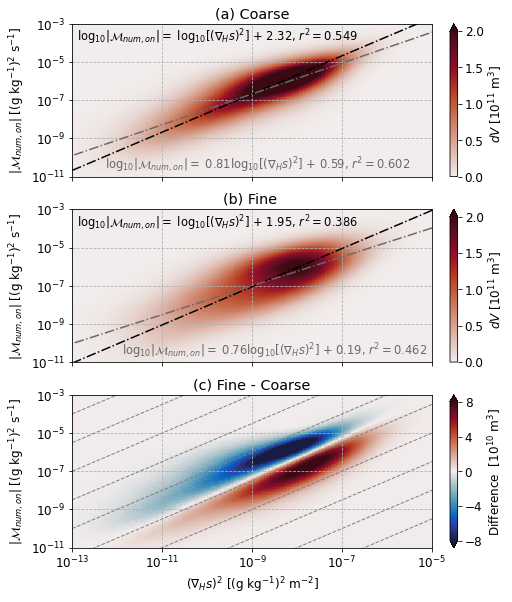

In [33]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(3,1, figsize = (7,2.5*3.3), sharex = True, sharey = True, constrained_layout = True)

mappable = (parent_joint.T/1e11).plot(ax = ax[0], cmap = cmo.amp, add_colorbar = False, vmin = 0, vmax = 2)
cbar = fig.colorbar(mappable, ax = ax[0], extend = 'max', label = r'$dV$ [$10^{11}$ m$^3$]', pad = 0.01)
mappable1 = (child_joint.T/1e11).plot(ax = ax[1], cmap = cmo.amp, add_colorbar = False, vmin = 0, vmax = 2)
cbar = fig.colorbar(mappable1, ax = ax[1], extend = 'max', label = r'$dV$ [$10^{11}$ m$^3$]', pad = 0.01)
mappable2 = (hist_diff.T/1e10).plot(ax = ax[2], cmap = cmo.balance, add_colorbar = False, vmin = -8, vmax = 8)
cbar = fig.colorbar(mappable2, ax = ax[2], extend = 'both', label = r'Difference  [$10^{10}$ m$^3$]', ticks = [-8,-4,0,4,8], pad = 0.01)

for i in range(3):
    ax[i].set_xlabel('')
    ax[i].set_yticks([-11, -9, -7,-5,-3])
    ax[i].set_xticks([-13, -11, -9, -7,-5])
    ax[i].set_yticklabels(['10$^{-11}$', '10$^{-9}$', '10$^{-7}$', '10$^{-5}$', '10$^{-3}$'])
ax[i].set_xticklabels(['10$^{-13}$', '10$^{-11}$', '10$^{-9}$', '10$^{-7}$', '10$^{-5}$'])

for i in range(3):
    ax[i].set_ylabel(r'$|\mathcal{M}_{num,on}|$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
    ax[i].grid(ls = '--')
    # ax[i].grid(ls = '--')
    
ax[0].set_title('(a) Coarse')
ax[1].set_title('(b) Fine ')
ax[2].set_title('(c) Fine - Coarse')
ax[2].set_xlabel(r'$(\nabla_H s)^2$ [(g kg$^{-1}$)$^2$ m$^{-2}$]')

ax[0].plot(xwhole, y_new1, lw = 1.5, ls = '-.', c = 'k')
ax[0].plot(xwhole, y_pred_weighted , lw = 1.5, ls = '-.', c = 'dimgrey')
ax[1].plot(xwhole_child, y_new_child, lw = 1.5, ls = '-.', c = 'k')
ax[1].plot(xwhole_child, y_pred_weighted_child, lw = 1.5, ls = '-.', c = 'dimgrey')

ax[0].text(-12.28, -10.6, r'$\log_{10}|\mathcal{M}_{num, on}|=$ ' + str(round(results_weighted['polynomial'][0], 2)) + r'$\log_{10}[(\nabla_H s)^2]$ + ' + str(round(np.abs(results_weighted['polynomial'][1]), 2)) + ', $r^2 = $' + str(round(r2, 3)), fontsize = 11.5, color = 'dimgrey')
ax[0].text(-12.9, -3.90, r'$\log_{10}|\mathcal{M}_{num, on}|=$ ' + r'$\log_{10}[(\nabla_H s)^2]$ + ' + str(round(b1[0],2)) + ', $r^2 = $' + str(round(r2_1, 3)), color = 'k', fontsize = 11.5)
ax[1].text(-11.9, -10.6, r'$\log_{10}|\mathcal{M}_{num, on}|=$ ' + str(round(results_weighted_child['polynomial'][0], 2)) + r'$\log_{10}[(\nabla_H s)^2]$ + ' + str(round(np.abs(results_weighted_child['polynomial'][1]), 2)) + ', $r^2 = $' + str(round(r2_child, 3)), fontsize = 11.5, color = 'dimgrey')
ax[1].text(-12.9, -3.90, r'$\log_{10}|\mathcal{M}_{num, on}|=$ ' + r'$\log_{10}[(\nabla_H s)^2]$ + ' + str(round(b_child[0],2)) + ', $r^2 = $' + str(round(r2_1_child, 3)), color = 'k', fontsize = 11.5)

#Add in lines with slope of 1 manually here. 
ax[2].plot(np.linspace(-13,-3, 200), np.linspace(-13,-3, 200) , lw = 1.0, c = 'grey', ls = '--')
ax[2].plot(np.linspace(-13,-3, 200), np.linspace(-13,-3, 200)+1.5, lw = 1.0, c = 'grey', ls = '--')
ax[2].plot(np.linspace(-13,-3, 200), np.linspace(-13,-3, 200)+3.0, lw = 1.0, c = 'grey', ls = '--')
ax[2].plot(np.linspace(-13,-3, 200), np.linspace(-13,-3, 200)+4.5, lw = 1.0, c = 'grey', ls = '--')
ax[2].plot(np.linspace(-13,-3, 200), np.linspace(-13,-3, 200)+6, lw = 1.0, c = 'grey', ls = '--')
ax[2].plot(np.linspace(-13,-3, 200), np.linspace(-13,-3, 200)+7.5, lw = 1.0, c = 'grey', ls = '--')
ax[2].plot(np.linspace(-13,-3, 200), np.linspace(-13,-3, 200)+9, lw = 1.0, c = 'grey', ls = '--')
ax[2].plot(np.linspace(-13,-3, 200), np.linspace(-13,-3, 200)-1.5, lw = 1.0, c = 'grey', ls = '--')
ax[2].plot(np.linspace(-13,-3, 200), np.linspace(-13,-3, 200)-3, lw = 1.0, c = 'grey', ls = '--')
ax[2].plot(np.linspace(-13,-3, 200), np.linspace(-13,-3, 200)-4.5, lw = 1.0, c = 'grey', ls = '--')
# ax[2].text(-8,-8.8, r'1:1', color = 'k')
fig.savefig('/d2/home/dylan/JAMES/figures/draft1/histogram_discussion_final.jpg', dpi = 300, bbox_inches="tight")    